# Introduction

## Foreword

Contains the three selected models for show:
- baseline performing
- experimental (data augmentation in preprocessing)
- best performing

Outputs exported to `../results/model_scores.csv`

## Problem Statement

The rapid evolution of generative artificial intelligence (GPAI, LLMs) social media has rapidly increased the public’s access to powerful, deceptive tools. One such concern is the increasing prevalence of deepfake images, which pose a significant threat to public trust and undermines the epistemic integrity of visual media.

These manipulated images can be utilized to spread false information, manipulate public opinion, and polarize communities, which can have serious consequences for both social and political discourse. This project aims to develop a machine learning model that can detect differences between deepfakes and real images to combat the spread of manipulated visual media and protect the integrity of social discourse.

## Imports, Global Variables, and Helper Functions

In [1]:
import sys
sys.path.append("../../helper/")
import config

In [3]:
# setting random value
config.set_random_seed(config.random_seed_value)

## Data Loading

In [ ]:
# extracting w/h
image_shape = config.img_to_array(config.load_img("../../../Data/Train/Real/real_1.jpg")).shape
w = image_shape[0]
h = image_shape[1]

In [ ]:
# setting filepaths to image data
train_directory = "../../../Data/Train"
validation_directory = "../../../Data/Validation/"
test_directory = "../../../Data/Test/"
directories = [train_directory, validation_directory, test_directory]

In [ ]:
# loading data
mega_data = []
for i in range(3):
    mega_data.append(config.image_dataset_from_directory(
        directory=directories[i],
        image_size=(w, h),
        batch_size=64,
        seed=config.random_seed_value,
        label_mode='binary'
    ))

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [ ]:
# variable names to data
train_ds = mega_data[0]
val_ds = mega_data[1]
test_ds = mega_data[2]

# Modeling

## Baseline Model (Sequential)

### Preprocessing (Topology + Compiling)

In [ ]:
# instantiate
model = config.Sequential()

# input layer
model.add(config.Input(shape=(w, h, 3)))
model.add(config.Rescaling(1./255))
model.add(config.BatchNormalization())

# convolutional layers
model.add(config.Dropout(0.3))
model.add(config.Conv2D(32, (3,3), activation="relu"))
model.add(config.MaxPooling2D(pool_size=(2,2)))

model.add(config.Dropout(0.3))
model.add(config.Conv2D(8, (3,3), activation="relu"))
model.add(config.MaxPooling2D(pool_size=(2,2)))

model.add(config.Flatten())

# hidden layers
model.add(config.Dropout(0.3))
model.add(config.Dense(32, activation="relu"))
model.add(config.BatchNormalization())

model.add(config.Dropout(0.3))
model.add(config.Dense(8, activation="relu"))
model.add(config.BatchNormalization())

# output layer
model.add(config.Dense(1, activation="sigmoid"))

# compile
model.compile(
    optimizer=config.Adam(learning_rate=0.005),
    loss=config.BinaryCrossentropy(),
    metrics=config.standard_metrics
)

### Fitting

In [ ]:
# es = EarlyStopping(patience=3)
reduce_lr = config.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                     patience=5, min_lr=0.0005)
res = model.fit(train_ds,
                validation_data=val_ds, 
                epochs=20,
                callbacks=[reduce_lr])

Epoch 1/20
2188/2188 [==============================] - 8408s 4s/step - loss: 0.4627 - binary_accuracy: 0.7749 - auc: 0.8582 - precision: 0.7561 - recall: 0.8115 - true_negatives: 51951.0000 - true_positives: 57086.0000 - false_positives: 18412.0000 - false_negatives: 13257.0000 - val_loss: 1.1873 - val_binary_accuracy: 0.7163 - val_auc: 0.7958 - val_precision: 0.6863 - val_recall: 0.8007 - val_true_negatives: 12398.0000 - val_true_positives: 15843.0000 - val_false_positives: 7243.0000 - val_false_negatives: 3944.0000 - lr: 0.0050
Epoch 2/20
2188/2188 [==============================] - 6818s 3s/step - loss: 0.3664 - binary_accuracy: 0.8339 - auc: 0.9153 - precision: 0.8190 - recall: 0.8572 - true_negatives: 56741.0000 - true_positives: 60008.0000 - false_positives: 13260.0000 - false_negatives: 9993.0000 - val_loss: 0.6442 - val_binary_accuracy: 0.7119 - val_auc: 0.8548 - val_precision: 0.6420 - val_recall: 0.9628 - val_true_negatives: 9020.0000 - val_true_positives: 19050.0000 - val_f

### Saving Files

In [ ]:
'''
loss: 0.2020 - binary_accuracy: 0.9176 - auc: 0.9747 - precision: 0.9100 - recall: 0.9270 - true_negatives: 63583.0000 - true_positives: 64889.0000 - false_positives: 6418.0000 - false_negatives: 5112.0000
val_loss: 0.4216 - val_binary_accuracy: 0.8216 - val_auc: 0.9169 - val_precision: 0.7723 - val_recall: 0.9139 - val_true_negatives: 14310.0000 - val_true_positives: 18083.0000 - val_false_positives: 5331.0000 - val_false_negatives: 1704.0000 - lr: 1.0000e-03
'''
data = [[0.2020, 0.9176, 0.9100, 0.9270, 0.9747, 5112, 6418, 63583, 64889, 0.4216, 0.8216, 0.7723, 0.9139, 0.9169, 1704, 5331, 14310, 18083]]
df = config.pd.DataFrame(data=config.np.array(data), columns=config.column_names, index=["cnn_baseline"])
df

,train_loss,train_acc,train_precision,train_recall,train_auc,train_fn,train_fp,train_tn,train_tp,val_loss,val_acc,val_precision,val_recall,val_auc,val_fn,val_fp,val_tn,val_tp
cnn_baseline,0.202,0.9176,0.91,0.927,0.9747,5112.0,6418.0,63583.0,64889.0,0.4216,0.8216,0.7723,0.9139,0.9169,1704.0,5331.0,14310.0,18083.0


## Experimental Model (EfficientNetV2L)

### Data Augmentation

In [ ]:
# test on single image
train_path = '../../../Dataset/Train/'

img = config.img_to_array(config.load_img(train_path + 'Fake/Fake_9.jpg'))

w = img.shape[0]
h = img.shape[1]

exp_img = config.np.expand_dims(img, axis=0)

In [ ]:
# setting up augmentation model
data_aug = config.Sequential([
    config.RandomFlip('horizontal', input_shape=(h,w,3)),
    config.RandomRotation(0.3),
    config.RandomZoom(0.3),
    config.RandomContrast(0.3)
])

In [ ]:
# test on single image
data_aug(exp_img)

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[196.12984   , 165.4487    , 144.61728   ],
         [196.73056   , 163.87068   , 141.74945   ],
         [196.88684   , 161.8581    , 139.00562   ],
         ...,
         [255.        , 255.        , 255.        ],
         [254.61365   , 255.        , 255.        ],
         [254.79167   , 255.        , 255.        ]],

        [[194.5486    , 164.73442   , 144.43854   ],
         [196.44452   , 164.07281   , 142.35818   ],
         [197.75334   , 162.76582   , 140.11298   ],
         ...,
         [255.        , 255.        , 255.        ],
         [255.        , 255.        , 255.        ],
         [255.        , 255.        , 255.        ]],

        [[193.11328   , 163.62352   , 144.09384   ],
         [196.12502   , 163.48703   , 142.43027   ],
         [198.57384   , 163.07516   , 140.82861   ],
         ...,
         [255.        , 255.        , 255.        ],
         [255.        , 255.        , 255.      

In [ ]:
# squeeze to normal image dimension
new_img = config.np.squeeze(exp_img)
new_img.shape

(256, 256, 3)

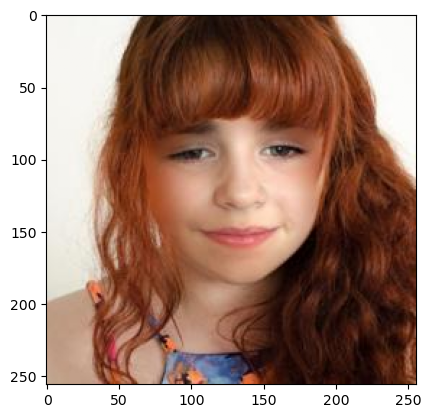

In [ ]:
config.plt.imshow(new_img * 1./255);

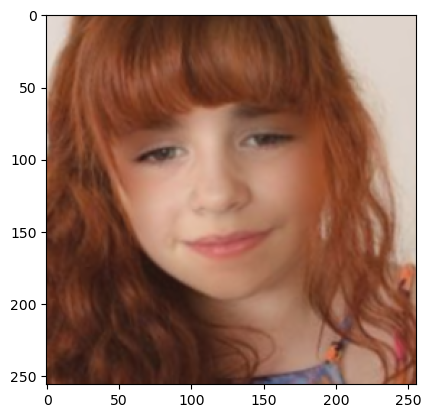

In [ ]:
# finalized function 
new_img_aug = config.data_augmentation(exp_img)
new_img = np.squeeze(new_img_aug)
config.plt.imshow(new_img * 1./255);

### Preprocessing (Topology + Compiling)

In [ ]:
model7 = config.Sequential()

effnet_V2L_pretrained = EfficientNetV2L(
    weights='imagenet',   
    input_shape=(h,w,3), 
    include_top=False,
    include_preprocessing=True #Efficientnet_2L expects [-1, 1] range, if set to False
)

effnet_V2L_pretrained.trainable = False

model7.add(data_aug)
model7.add(effnet_V2L_pretrained)

model7.add(config.GlobalAveragePooling2D())

model7.add(config.Dense(256, activation='relu'))
model7.add(config.BatchNormalization())
model7.add(config.Dropout(0.3))

model7.add(config.Dense(units = 1, activation='sigmoid'))
model7.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 8, 8, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                      

In [ ]:
# compile
model7.compile(
    optimizer='adam',
    loss = 'bce',
    metrics = ['acc', 
                config.Precision(), config.Recall(), 
                config.AUC(),
                config.FalseNegatives(), config.FalsePositives(),
                config.TrueNegatives(),
                config.TruePositives()]
)

### Fitting

In [ ]:
# es = EarlyStopping(patience=3)
reduce_lr = config.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                     patience=5, min_lr=0.0005)
res = model.fit(train_ds,
                validation_data=val_ds, 
                epochs=20,
                callbacks=[reduce_lr])

Epoch 1/20
2188/2188 [==============================] - 8408s 4s/step - loss: 0.4627 - binary_accuracy: 0.7749 - auc: 0.8582 - precision: 0.7561 - recall: 0.8115 - true_negatives: 51951.0000 - true_positives: 57086.0000 - false_positives: 18412.0000 - false_negatives: 13257.0000 - val_loss: 1.1873 - val_binary_accuracy: 0.7163 - val_auc: 0.7958 - val_precision: 0.6863 - val_recall: 0.8007 - val_true_negatives: 12398.0000 - val_true_positives: 15843.0000 - val_false_positives: 7243.0000 - val_false_negatives: 3944.0000 - lr: 0.0050
Epoch 2/20
2188/2188 [==============================] - 6818s 3s/step - loss: 0.3664 - binary_accuracy: 0.8339 - auc: 0.9153 - precision: 0.8190 - recall: 0.8572 - true_negatives: 56741.0000 - true_positives: 60008.0000 - false_positives: 13260.0000 - false_negatives: 9993.0000 - val_loss: 0.6442 - val_binary_accuracy: 0.7119 - val_auc: 0.8548 - val_precision: 0.6420 - val_recall: 0.9628 - val_true_negatives: 9020.0000 - val_true_positives: 19050.0000 - val_f

In [ ]:
h7 = model7.fit(train, validation_data = val, epochs = 10, callbacks = [reduce_lr, es])

Epoch 1/10
4376/4376 [==============================] - 2174s 493ms/step - loss: 0.5328 - acc: 0.7320 - precision_4: 0.7242 - recall_4: 0.7492 - auc_4: 0.8091 - false_negatives_4: 17556.0000 - false_positives_4: 19971.0000 - true_negatives_4: 50037.0000 - true_positives_4: 52446.0000 - val_loss: 0.4999 - val_acc: 0.7614 - val_precision_4: 0.7886 - val_recall_4: 0.7168 - val_auc_4: 0.8441 - val_false_negatives_4: 5608.0000 - val_false_positives_4: 3804.0000 - val_true_negatives_4: 15851.0000 - val_true_positives_4: 14192.0000 - lr: 0.0010
Epoch 2/10
4376/4376 [==============================] - 2089s 477ms/step - loss: 0.4975 - acc: 0.7530 - precision_4: 0.7434 - recall_4: 0.7726 - auc_4: 0.8352 - false_negatives_4: 15915.0000 - false_positives_4: 18670.0000 - true_negatives_4: 51338.0000 - true_positives_4: 54087.0000 - val_loss: 0.4801 - val_acc: 0.7704 - val_precision_4: 0.8098 - val_recall_4: 0.7090 - val_auc_4: 0.8568 - val_false_negatives_4: 5762.0000 - val_false_positives_4: 3297.

In [ ]:
# Evaluate last epoch Train and Test Loss and Accuracy scores
print(f"Train Loss: {h7.history['loss'][-1]}\n\
Val Loss: {h7.history['val_loss'][-1]}\n\
Train Acc: {h7.history['acc'][-1]}\n\
Val Acc: {h7.history['val_acc'][-1]}")

Train Loss: 0.466923326253891
Val Loss: 0.4741072356700897
Train Acc: 0.7735375761985779
Val Acc: 0.7795209884643555


### Saving Files

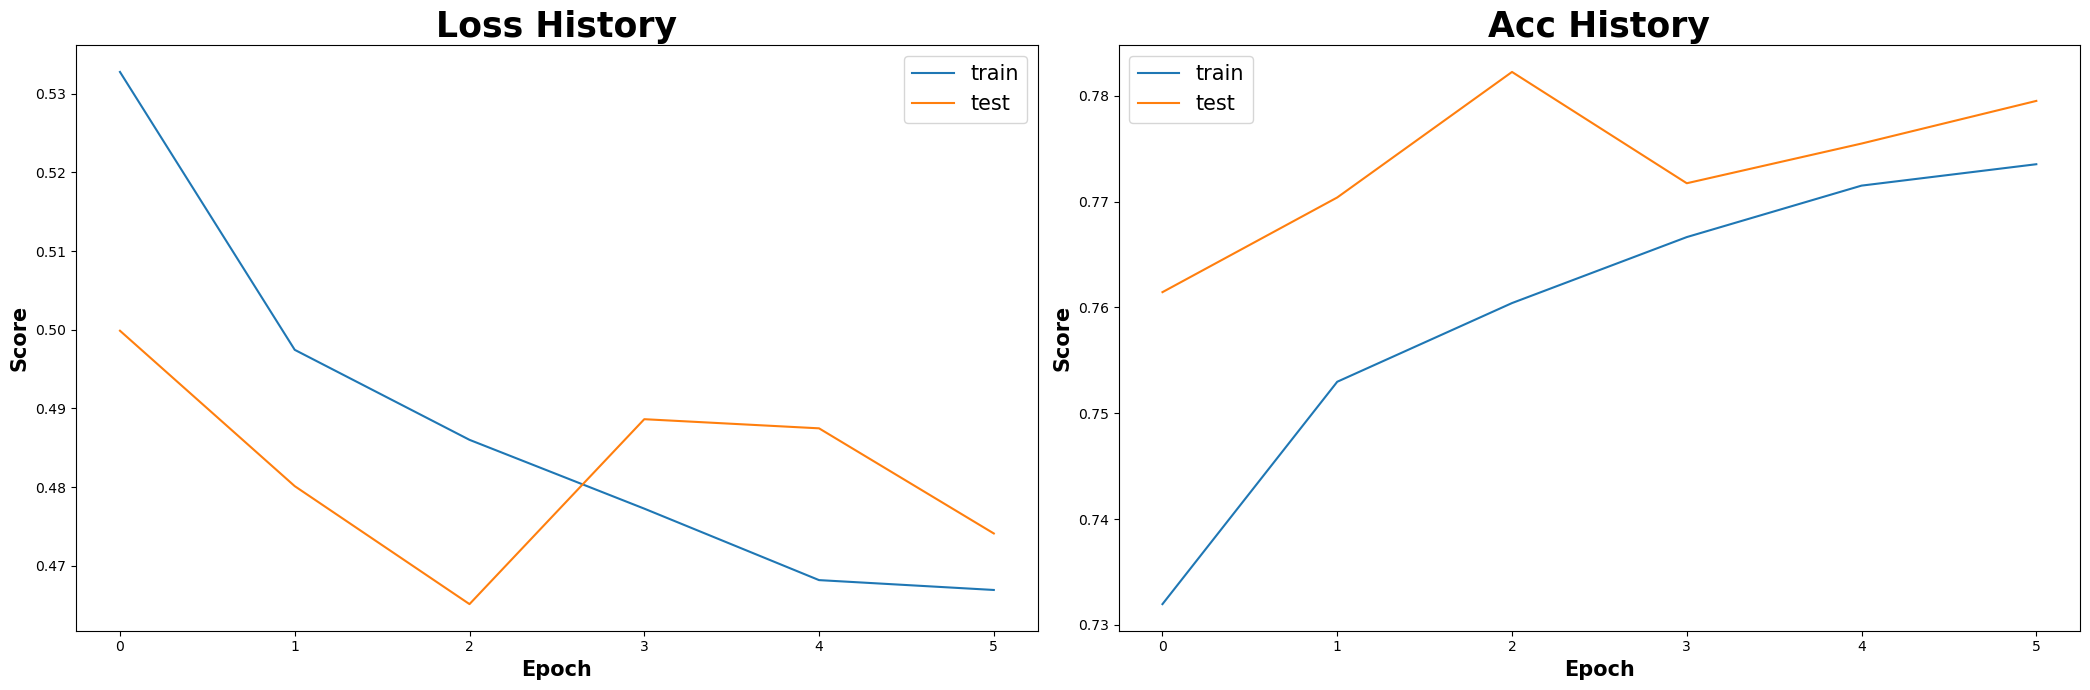

<Figure size 640x480 with 0 Axes>

In [ ]:
config.graph_me(h7, ['acc'])
config.plt.savefig('model7_r.png')
config.plt.show();

In [ ]:
# Append last epoch scores to model_eval.csv 
config.model_scores_to_csv(model7, h7, 'model_7')

In [ ]:
df = config.pd.read_csv('../../Results/model_eval_anna.csv')

df.set_index('Unnamed: 0', inplace=True)
df.drop('models', inplace=True)
df.index.name = 'models'
df

,train_loss,train_acc,train_precision,train_recall,train_auc,train_fn,train_fp,train_tn,train_tp,val_loss,val_acc,val_precision,val_recall,val_auc,val_fn,val_fp,val_tn,val_tp
models,,,,,,,,,,,,,,,,,,
model_1,0.046418,0.983007,0.981008,0.985086,0.998207,1044.0,1335.0,68666.0,68957.0,0.728149,0.859973,0.848666,0.877445,0.918686,2425.0,3096.0,16545.0,17362.0
model_2,0.027057,0.990694,0.990238,0.991157,0.999172,619.0,684.0,69324.0,69383.0,0.457394,0.910100,0.876349,0.955707,0.957809,877.0,2670.0,16985.0,18923.0
model_3,0.037152,0.986929,0.986345,0.987529,0.998717,873.0,957.0,69051.0,69129.0,0.487295,0.792878,0.840637,0.724647,0.886185,5452.0,2720.0,16935.0,14348.0
model_4,0.036311,0.986794,0.986300,0.987300,0.998825,889.0,960.0,69048.0,69113.0,0.260117,0.918135,0.914167,0.923586,0.969956,1513.0,1717.0,17938.0,18287.0
model_5,0.092766,0.974295,0.973017,0.975644,0.996733,1705.0,1894.0,68114.0,68297.0,0.418766,0.878393,0.827841,0.956616,0.957764,859.0,3939.0,15716.0,18941.0
model_6,0.135484,0.946475,0.943747,0.949544,0.988435,3532.0,3962.0,66046.0,66470.0,0.286400,0.891167,0.887456,0.896869,0.956441,2042.0,2252.0,17403.0,17758.0
model_7,0.466923,0.773538,0.764625,0.790349,0.857355,14676.0,17031.0,52977.0,55326.0,0.474107,0.779521,0.822347,0.715152,0.865756,5640.0,3059.0,16596.0,14160.0


## Best Model (EfficientNetV2B0)

### Preprocessing (Topology + Compiling)

In [ ]:
model = config.Sequential()

effnet_V2L = config.EfficientNetV2B0(
    weights='imagenet',   
    input_shape=(h,w,3), 
    include_top=False,
    pooling='max',
    classes = 2,
    include_preprocessing=True     #Efficientnet_2L expects [-1, 1] range, if set to False
)

effnet_V2L.trainable = True

model.add(effnet_V2L)

model.add(config.Dense(1, activation='sigmoid'))

24289280/24274472 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=config.Adam(learning_rate=0.00001),
    loss='bce',
    metrics=['acc']
)

### Fitting

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2023-05-18 17:28:48.608097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - ETA: 0s - loss: 0.3019 - acc: 0.8872

2023-05-18 18:28:05.681589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - 3784s 2s/step - loss: 0.3019 - acc: 0.8872 - val_loss: 0.2602 - val_acc: 0.9033
Epoch 2/10
2188/2188 [==============================] - 3909s 2s/step - loss: 0.1009 - acc: 0.9617 - val_loss: 0.1820 - val_acc: 0.9311
Epoch 3/10
2188/2188 [==============================] - 3566s 2s/step - loss: 0.0610 - acc: 0.9765 - val_loss: 0.1432 - val_acc: 0.9465
Epoch 4/10
2188/2188 [==============================] - 3557s 2s/step - loss: 0.0392 - acc: 0.9851 - val_loss: 0.1265 - val_acc: 0.9544
Epoch 5/10
2188/2188 [==============================] - 3501s 2s/step - loss: 0.0252 - acc: 0.9910 - val_loss: 0.1173 - val_acc: 0.9590
Epoch 6/10
2188/2188 [==============================] - 3449s 2s/step - loss: 0.0170 - acc: 0.9944 - val_loss: 0.1168 - val_acc: 0.9614
Epoch 7/10
2188/2188 [==============================] - 3435s 2s/step - loss: 0.0120 - acc: 0.9961 - val_loss: 0.1092 - val_acc: 0.9649
Epoch 8/10
2188/2188 [==============================] - 358

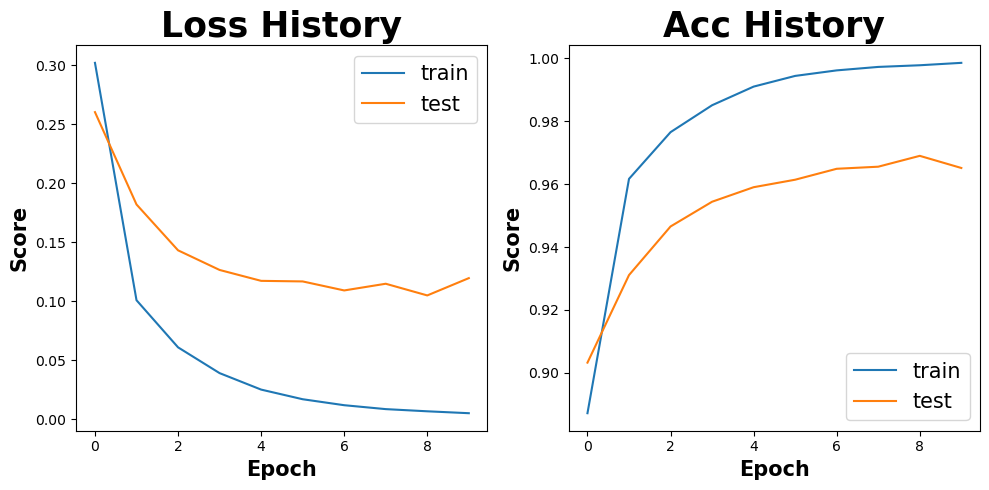

In [ ]:
config.graph_me(history, ['acc'])